# Triple Tank System

In this Jupyter Notebook we illustrate the example **Triple Tank**.

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/do-mpc/do-mpc.git/master?filepath=%2Fdocumentation%2Fsource%2Fexample_gallery%2FCSTR.ipynb)

The example consists of the three modules **template_model.py**, which describes the system model and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for simulation of the plant.
One exemplary result will be presented at the end of this tutorial as a gif.

In the following the different parts are presented. But first, we start by importing basic modules and **do-mpc**.

In [1]:
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

# import other necessary packages
import numpy as np
import matplotlib.pyplot as plt

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/PAS/Work/do-mpc-naskar/documentation/source/example_gallery/../../../do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/PAS/Work/do-mpc-naskar/documentation/source/example_gallery/../../../do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## Example Description
In this exercise, we will perform state estimation of a triple tank systems using an Extended Kalman Filter (EKF) as shown in the following diagram<span class="graffiti-highlight graffiti-id_tgqkk3x-id_23yzj32"><i></i></span> [[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8879526).




<img src="./three_tank_system.png" style="width: 60%;" align="center"/>


The plant consists of three tanks with a cross-sectional area $A$. They are connected serially together through connecting pipes with cross-sectional area $S_{p}$. The input to the system is through two pumps. The flow of both pumps is assumed to be **constant**. Our states ($x_1$, $x_2$, and $x_3$) are the level of water in each of the tanks. We assume the water level in tank three is measured. The water level in each of the tanks can be described by the following equations.

\begin{align}
\frac{dx_1}{dt} &= \frac{-q_{13}(k)+u_1(k)}{A} \\
\frac{dx_2}{dt} &= \frac{q_{32}(k)-q_{20}+u_2(k)}{A} \\
\frac{dx_3}{dt} &= \frac{q_{13}(k)-q_{32}}{A} \\
\end{align}

where, 

\begin{align}
q_{13}(k) &= r_{1}S_{p}Sign(x_1(k)-x_3(k))\sqrt{2g|x_1(k)-x_3(k)|} \\
q_{32}(k) &= r_3S_pSign(x_3(k)-x_2(k))\sqrt{2g|x_3(k)-x_2(k)|} \\
q_{20}(k) &= r_2S_p\sqrt{2gx_2(k)} \\
\end{align}

The cross-sectional area A of the three tanks is $0.00154$ $m^2$. The outflow coefficients $r_i$ of the pipes are 1, 0.8, and 1 respectively. The connecting pipes are assumed to have a cross-sectional area of $S_p = 5\times10^{-5}$. The flow rate of both pumps is $u_1=u_2=1\times 10^{-4}$. The sampling time $T_s$ is fixed for one second.\
\
**Note**: $q_{1f}$ and $q_{2f}$ are disturbances to the plant and are assumed to be zero. 

## Continious

### Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the Triple Tank is discrete and has 3 states and 2 control inputs.
The model is initiated by:

In [2]:
# model type
model_type = 'continuous'

# initialisation of model
continuous_model = do_mpc.model.Model(model_type=model_type, symvar_type='SX')

#### States and control inputs

The three states are height of tank 1 ($x_{\text{1}}$), the height of tank 2 ($x_{\text{2}}$), the height of tank 3 ($x_{\text{3}}$):

In [3]:
# states
x1 = continuous_model.set_variable(var_type='_x', var_name='x1')
x2 = continuous_model.set_variable(var_type='_x', var_name='x2')
x3 = continuous_model.set_variable(var_type='_x', var_name='x3')

The control inputs are the flowrate to tank 1 ($u_{\text{1}}$) and the flowrate to tank 2 ($u_{\text{2}}$):

In [4]:
# inputs
u1 = continuous_model.set_variable(var_type='_u', var_name='u1')
u2 = continuous_model.set_variable(var_type='_u', var_name='u2')

In this example only the height of tank 3 ($x_{\text{3}}$) is measured:

In [5]:
# State measurements
continuous_model.set_meas('x3_meas', x3)

SX((x3+x3_meas_noise))

The fixed parameters are stored here as per the description:

In [6]:
# defining auxiliary variables
A = 0.00154
g = 9.81
Ts = 1
r1 = 1
r2 = 0.8
r3 = 1
sp = 5 * 1e-5
q13 = r1 * sp * sign(x1 - x3) * sqrt(2 * g * fabs(x1 - x3))
q32 = r3 * sp * sign(x3 - x2) * sqrt(2 * g * fabs(x3 - x2))
q20 = r2 * sp * sqrt(2 * g * x2)

The syetem is modelled here using the following discretised euqations:

In [7]:
# model equations
x1_dot = (-q13 + u1)/A
x2_dot = (q32 - q20 + u2)/A
x3_dot = (q13 - q32)/A

The generated quations are now pushed to the do-mpc class:

In [8]:
# saving equations
continuous_model.set_rhs('x1', x1_dot)
continuous_model.set_rhs('x2', x2_dot)
continuous_model.set_rhs('x3', x3_dot)

Finally, the model setup is completed:

In [9]:
# setup
continuous_model.setup()

### Simulator

The simulator is initialed by:

In [10]:
# init
continuous_simulator = do_mpc.simulator.Simulator(continuous_model)

The time step is stored:

In [11]:
# time step
continuous_simulator.set_param(t_step = 1)

Finally, the simulator is set up:

In [12]:
# simulator setup
continuous_simulator.setup()

### EKF Description

The EKF does not require any special attenting as the example does not have any do-mpc parameters or time varying parameters.

The EKF is initiated by:

In [13]:
# init
continuous_ekf = do_mpc.estimator.EKF(model=continuous_model)

The time step is stored:

In [14]:
# time step
continuous_ekf.settings.t_step = 1

Finally, the EKF is set up:

In [15]:
# ekf setup
continuous_ekf.setup()

CasADi - 2025-03-19 15:55:40 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


### Simulation

For the simulation of the Triple Tank, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [16]:
# initial states of model
x0_true = np.array([2, 2.8, 2.7]).reshape([-1, 1])
x0 = np.array([1.2, 1.4, 1.8]).reshape([-1, 1])

# pushing the initial states
continuous_simulator.x0 = x0_true
continuous_ekf.x0 = x0

# priming the objects for furthur steps
continuous_simulator.set_initial_guess()
continuous_ekf.set_initial_guess()

The domain of the simulation is stored:

In [17]:
N_sim = 200

The EKF can be tuned by choosing appropriate values of $Q$ and $R$.

$Q$ needs to be of shape [$n_{\text{x}}$ * $n_{\text{x}}$].

$R$ needs to be of shape [$n_{\text{y}}$ * $n_{\text{y}}$].

The values here are found out by trial and error, it is possible to find better values for the alogorithm.

In [18]:
# ekf parameter
q = 1e-3 * np.ones(continuous_model.n_x)
r = 1e-1 * np.ones(continuous_model.n_y)

# creating diagonal matrics with appropriate shape
Q = np.diag(q.flatten())
R = np.diag(r.flatten())

Storing values for further plots:

In [19]:
x0_simulator = [x0_true]
x0_ekf = [x0]

It is assumed that the system gets an input of:

$u_{\text{1}}$ = 0.0001,
$u_{\text{2}}$ = 0.0001

Now we simulate the system:

In [20]:
for k in range(N_sim):
    
    # input defined by the problem
    u0 = np.array([0.0001, 0.0001]).reshape([-1, 1])

    # Simulate with process and measurement noise
    y_next = continuous_simulator.make_step(u0, v0=0.1*np.random.randn(continuous_model.n_v,1))

    # state setimation with ekf
    x0 = continuous_ekf.make_step(y_next = y_next, u_next = u0, Q_k=Q, R_k=R)

    # results stored for plotting
    x0_simulator.append(continuous_simulator._x0.master)
    x0_ekf.append(x0)

### Plots
The obtained reualt is plotted:

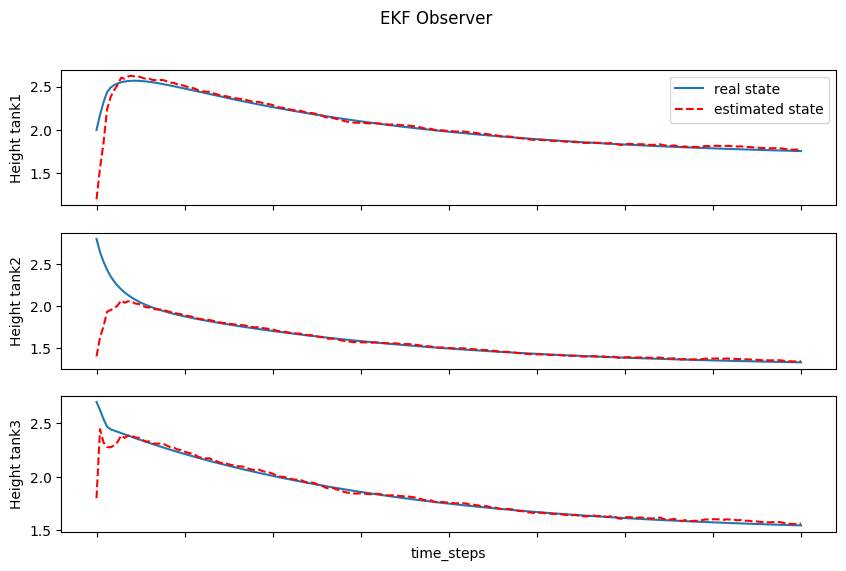

In [21]:
def visualize(nx, x_data, x_hat_data):
    x_data = np.concatenate(x_data, axis=1)
    x_hat_data = np.concatenate(x_hat_data, axis=1)

    fig, ax = plt.subplots(nx, figsize=(10, 6))
    fig.suptitle('EKF Observer')

    for i in range(nx):
        ax[i].plot(x_data[i, :], label='real state')
        ax[i].plot(x_hat_data[i, :],"r--", label='estimated state')
        ax[i].set_xticklabels([])
        ax[i].set_ylabel(f'Height tank{i+1}')

    ax[-1].set_xlabel('time_steps')
    ax[0].legend()
    plt.show()

visualize(3, x0_simulator, x0_ekf)


## Discrete

Discretising the differential euqations with Euler Forward difference method we get:

\begin{align}
{x_1}(k+1) &= x_1(k)+ \frac{T_s}{A}(-q_{13}(k)+u_1(k)) \\
{x_2}(k+1) &= x_2(k)+ \frac{T_s}{A}(q_{32}(k)-q_{20}+u_2(k)) \\
{x_3}(k+1) &= x_3(k)+ \frac{T_s}{A}(q_{13}(k)-q_{32}) \\
\end{align}

### Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the Triple Tank is discrete and has 3 states and 2 control inputs.
The model is initiated by:

In [22]:
# initialisation of model
discrete_model = do_mpc.model.Model(model_type='discrete', symvar_type='SX')

#### States and control inputs

The three states are height of tank 1 ($x_{\text{1}}$), the height of tank 2 ($x_{\text{2}}$), the height of tank 3 ($x_{\text{3}}$):

In [23]:
# states
x1 = discrete_model.set_variable(var_type='_x', var_name='x1')
x2 = discrete_model.set_variable(var_type='_x', var_name='x2')
x3 = discrete_model.set_variable(var_type='_x', var_name='x3')

The control inputs are the flowrate to tank 1 ($u_{\text{1}}$) and the flowrate to tank 2 ($u_{\text{2}}$):

In [24]:
# inputs
u1 = discrete_model.set_variable(var_type='_u', var_name='u1')
u2 = discrete_model.set_variable(var_type='_u', var_name='u2')

In this example only the height of tank 3 ($x_{\text{3}}$) is measured:

In [25]:
# State measurements
discrete_model.set_meas('x3_meas', x3)

SX((x3+x3_meas_noise))

The fixed parameters are stored here as per the description:

In [26]:
# defining auxiliary variables
A = 0.00154
g = 9.81
Ts = 1
r1 = 1
r2 = 0.8
r3 = 1
sp = 5 * 1e-5
q13 = r1 * sp * sign(x1 - x3) * sqrt(2 * g * fabs(x1 - x3))
q32 = r3 * sp * sign(x3 - x2) * sqrt(2 * g * fabs(x3 - x2))
q20 = r2 * sp * sqrt(2 * g * x2)

The syetem is modelled here using the following discretised euqations:

In [27]:
# model equations
x1_next = x1 + (Ts / A) * (-q13 + u1)
x2_next = x2 + (Ts / A) * (q32 - q20 + u2)
x3_next = x3 + (Ts / A) * (q13 - q32)

The generated quations are now pushed to the do-mpc class:

In [28]:
# saving equations
discrete_model.set_rhs('x1', x1_next)
discrete_model.set_rhs('x2', x2_next)
discrete_model.set_rhs('x3', x3_next)

Finally, the model setup is completed:

In [29]:
# setup
discrete_model.setup()

### Simulator

The simulator is initialed by:

In [30]:
# init
discrete_simulator = do_mpc.simulator.Simulator(discrete_model)

The time step is stored:

In [31]:
# time step
discrete_simulator.set_param(t_step = 1)

Finally, the simulator is set up:

In [32]:
# simulator setup
discrete_simulator.setup()

### EKF Description

The EKF does not require any special attenting as the example does not have any do-mpc parameters or time varying parameters.

The EKF is initiated by:

In [33]:
# init
discrete_ekf = do_mpc.estimator.EKF(model=discrete_model)

The time step is stored:

In [34]:
# time step
discrete_ekf.settings.t_step = 1

Finally, the EKF is set up:

In [35]:
# ekf setup
discrete_ekf.setup()

### Simulation

For the simulation of the Triple Tank, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [36]:
# initial states of model
x0_true = np.array([2, 2.8, 2.7]).reshape([-1, 1])
x0 = np.array([1.2, 1.4, 1.8]).reshape([-1, 1])

# pushing the initial states
discrete_simulator.x0 = x0_true
discrete_ekf.x0 = x0

# priming the objects for furthur steps
discrete_simulator.set_initial_guess()
discrete_ekf.set_initial_guess()

The domain of the simulation is stored:

In [37]:
N_sim = 200

The EKF can be tuned by choosing appropriate values of $Q$ and $R$.

$Q$ needs to be of shape [$n_{\text{x}}$ * $n_{\text{x}}$].

$R$ needs to be of shape [$n_{\text{y}}$ * $n_{\text{y}}$].

The values here are found out by trial and error, it is possible to find better values for the alogorithm.

In [38]:
# ekf parameter
q = 1e-3 * np.ones(discrete_model.n_x)
r = 1e-2 * np.ones(discrete_model.n_y)

# creating diagonal matrics with appropriate shape
Q = np.diag(q.flatten())
R = np.diag(r.flatten())

Storing values for further plots:

In [39]:
x0_simulator = [x0_true]
x0_ekf = [x0]

It is assumed that the system gets an input of:

$u_{\text{1}}$ = 0.0001,
$u_{\text{2}}$ = 0.0001

Now we simulate the system:

In [40]:
for k in range(N_sim):
    
    # input defined by the problem
    u0 = np.array([0.0001, 0.0001]).reshape([-1, 1])

    # Simulate with process and measurement noise
    y_next = discrete_simulator.make_step(u0, v0=0.01*np.random.randn(discrete_model.n_v,1))

    # state setimation with ekf
    x0 = discrete_ekf.make_step(y_next = y_next, u_next = u0, Q_k=Q, R_k=R)

    # results stored for plotting
    x0_simulator.append(discrete_simulator._x0.master)
    x0_ekf.append(x0)

### Plots
The obtained reualt is plotted:

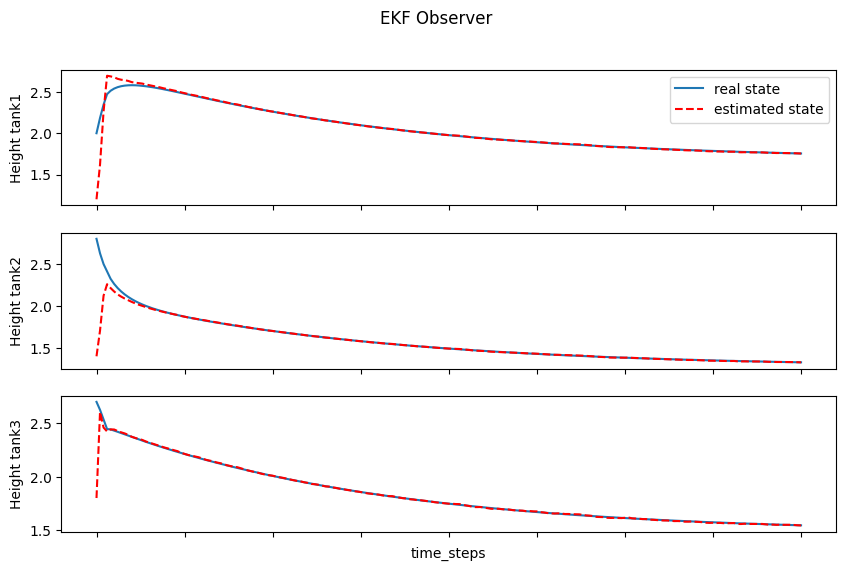

In [41]:
visualize(3, x0_simulator, x0_ekf)
